In [23]:
import sqlite3
from sqlite3 import Error
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from matplotlib.pyplot import figure
import matplotlib.image as mpimg
import math
from scipy.stats import t

class StdevFunc:
    def __init__(self):
        self.M = 0.0
        self.S = 0.0
        self.k = 1

    def step(self, value):
        if value is None:
            return
        tM = self.M
        self.M += (value - tM) / self.k
        self.S += (value - tM) * (value - self.M)
        self.k += 1

    def finalize(self):
        if self.k < 3:
            return None
        return math.sqrt(self.S / (self.k-2))

# Data Downloaded from https://www.kaggle.com/rhuebner/human-resources-data-set/download

conn = sqlite3.connect('hr.db')
df = pd.read_csv('HRDataset_v13.csv')
df.to_sql('hr', conn, if_exists='replace', index=False)
conn.create_aggregate("stdev", 1, StdevFunc)
cur = conn.cursor()


In [24]:
print("Only choose one zip code")
query =  """SELECT Zip, count(*) AS N 
            FROM hr
            GROUP BY Zip
            ORDER BY N DESC
            LIMIT 5;"""
cur.execute(query)
rows = cur.fetchall()
print(rows) 
print('No, max 13 obs in one zip code')

Only choose one zip code
[(None, 91), (1886.0, 13), (1810.0, 7), (2045.0, 7), (2176.0, 7)]
No, max 13 obs in one zip code


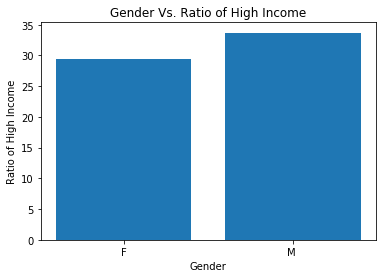

In [27]:
query =  """SELECT Sex, AVG(PayRate), stdev(PayRate), count(*)
            FROM hr
            GROUP BY Sex;"""
cur.execute(query)
rows = cur.fetchall()
del rows[0]

gender = []
income = []
for row in rows:
    gender.append(row[0])
    income.append(row[1])
    
genderVsIncome = (gender, income)

plt.bar(*genderVsIncome);
plt.ylabel('Ratio of High Income');
plt.xlabel('Gender');
plt.title("Gender Vs. Ratio of High Income");

In [46]:
muF  = rows[0][1] 
muM  = rows[1][1] 
stdF = rows[0][2] 
stdM = rows[1][2] 
NF   = rows[0][3] 
NM   = rows[1][3] 

# Consructing p-value using a t-test to test if average pay rate for males equal females
testStatistic = (muF-muM)/math.sqrt(stdF**2/NF+stdM**2/NM)
degOfFreedom  =  (stdF**2/NF+stdM**2/NM)**2/(((stdF**2/NF)**2)*(NF-1) + ((stdM**2/NM)**2)*(NM-1))
p_value = 2*abs(t.cdf(testStatistic, degOfFreedom, loc=0, scale=1))
p_value

0.9523212648235388

As the p-value is so large (larger than .05/.1...) we fail to reject the null hypotheses so $E(PayRate|Male) = E(PayRate|Female)$ 